In [1]:
import snap
import os
import re
import math
import numpy as np
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [5]:
import estimation_function

df = estimation_function.estimation_function_test_paper(N=100)

No. nodes: 100; No. edges: 100
No. nodes: 100; No. edges: 200
No. nodes: 100; No. edges: 300
No. nodes: 100; No. edges: 400
No. nodes: 100; No. edges: 500


In [6]:
df.tail(10)

,Iteration,Size,Graph type,No. roots,No. nodes,No. edges,Max degree,Zero degree,TC size,Estimate
40,1,100500,Random,100,100,500,19,0,9801,9816.843611
41,1,100500,Scale-free,100,100,480,30,1,9604,9776.292281
42,2,100500,Random,100,100,500,17,0,9705,9816.843611
43,2,100500,Scale-free,100,100,485,29,0,9900,9787.202636
44,3,100500,Random,100,100,500,17,0,10000,9816.843611
45,3,100500,Scale-free,100,100,490,28,0,10000,9797.580886
46,4,100500,Random,100,100,500,17,0,10000,9816.843611
47,4,100500,Scale-free,100,100,480,25,2,9606,9776.292281
48,5,100500,Random,100,100,500,19,0,9410,9816.843611
49,5,100500,Scale-free,100,100,480,30,1,9505,9776.292281


In [7]:
df['aux'] = (df['Estimate'] - df['TC size']).abs()
df['Relative error'] = df.aux.div(df['TC size'].where(df['TC size']!=0, np.nan)) * 100
df = df.drop('aux', axis = 1)
df_tmp = df.groupby(['Size','Graph type'])['Relative error'].mean()

df_tmp.head(20)
# sns.catplot(x='Size', y='Relative error', order='Graph type',
#             kind="bar", estimator=np.mean, data=df)
# plt.show()

Size    Graph type
100100  Random        100.000000
        Scale-free    101.836542
100200  Random          6.509593
        Scale-free     16.367264
100300  Random          3.270844
        Scale-free      5.465504
100400  Random          1.874352
        Scale-free      2.155925
100500  Random          1.860148
        Scale-free      1.916900
Name: Relative error, dtype: float64

In [32]:
# g = nx.barabasi_albert_graph(100, 5)
g = nx.extended_barabasi_albert_graph(100, 5, 0.001, 0.9)
network_sf = snap.TNEANet.New()
for n in g.nodes():
    network_sf.AddNode(n)
for (s,d) in g.edges():
    network_sf.AddEdge(s, d)
print(network_sf.GetNodes(), network_sf.GetEdges())
print(g)
n_deg_z = 0
max_deg = 0
for (nid, deg) in g.degree:
    if deg == 0:
        n_deg_z += 1
    if deg > max_deg:
        max_deg = deg
print(f'Max: {max_deg}; Z: {n_deg_z}')


100 475
Graph with 100 nodes and 475 edges
Max: 30; Z: 1


In [46]:
# Network = snap.GenRndPowerLaw(1000, 1.3, True, snap.TRnd())
Network = snap.GenPrefAttach(1000, 2, snap.TRnd())
# Network = snap.GenRndGnm(snap.TNEANet, 10000, 50000, True)
print(Network.GetNodes(), Network.GetEdges(), Network.GetNodes()-Network.CntNonZNodes())
# for EI in Network.Edges():
#     print("edge: (%d, %d)" % (EI.GetSrcNId(), EI.GetDstNId()))

1000 1997 0


In [3]:
# Global variables
__datasets_info_df__ = pd.read_csv('docs/datasets_info.csv')
__datasets_info_df__['Size'] = __datasets_info_df__['No. nodes'] + __datasets_info_df__['No. edges']
# __ds_ordered_nodes__ = ['wiki-Vote', 'soc-Epinions1', 'web-NotreDame', 'twitter_combined', 'web-Stanford']
__ds_ordered_nodes__ = __datasets_info_df__.sort_values('No. nodes')['Dataset'].tolist()
__ds_ordered_edges__ = __datasets_info_df__.sort_values('No. edges')['Dataset'].tolist()
__ds_ordered_size__ = __datasets_info_df__.sort_values('Size')['Dataset'].tolist()
__ds_palette__ = dict(zip(__ds_ordered_size__, sns.color_palette(n_colors=len(__ds_ordered_size__))))
print(__ds_palette__)
print(__ds_ordered_nodes__)
print(__ds_ordered_edges__)
print(__ds_ordered_size__)

{'wiki-Vote': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'soc-Epinions1': (1.0, 0.4980392156862745, 0.054901960784313725), 'web-NotreDame': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), 'twitter_combined': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), 'web-Stanford': (0.5803921568627451, 0.403921568627451, 0.7411764705882353)}
['wiki-Vote', 'soc-Epinions1', 'twitter_combined', 'web-Stanford', 'web-NotreDame']
['wiki-Vote', 'soc-Epinions1', 'web-NotreDame', 'web-Stanford', 'twitter_combined']
['wiki-Vote', 'soc-Epinions1', 'web-NotreDame', 'twitter_combined', 'web-Stanford']


In [4]:
def summary_compression_plot(df: pd.DataFrame, scatter_plots_args: list[dict]):
    """"Makes scatterplots from the dataframe and scatter plots arguments given
    in scatter_plots_args.

    Args:
        df (pd.DataFrame): The dataframe in question.
        scatter_plots_args (list[dict]): A list of dictionaries, where each
            dictionary contains the arguments 'x', 'y', and 'hue' for the 
            scatterplot.
    """
    no_graphs = len(scatter_plots_args)
    no_cols = 3
    no_rows = math.ceil(no_graphs / no_cols)
    f, axs = plt.subplots(nrows=no_rows, ncols=no_cols, figsize=(
        5*no_cols, 4*no_rows))
    for idx, args in enumerate(scatter_plots_args):
        df = df.sort_values(by=[args['x']], key=pd.to_numeric)
        row = math.floor(idx/no_cols)
        col = idx % no_cols
        axs_idx = ((no_cols - 1)*row + row + col)
        g = sns.scatterplot(
            data=df, x=args['x'], y=args['y'], hue=args['hue'], ax=axs.flatten()[axs_idx])
        g.yaxis.set_major_formatter(mtick.PercentFormatter())
    f.tight_layout()
    plt.show()

def summary_data_cleaning(df: pd.DataFrame, is_labeled: bool) -> list[dict]:
    """Prepares dataframe for generating the plots and returns a list of dicts,
    where each dict has the arguments for each scatter plot.

    Args:
        df (pd.Dataframe): the dataframe containing the summary data
        is_labeled (bool): whether the data relates to a labeled graph or not

    Returns:
        list[dict]: each dict contains the arguments for a scatter plot
    """
    for column in df:
        drop_words: list[str] = ['Sketch', 'time', 'degree']
        if any(word in column for word in drop_words):
            df.drop(column, axis=1, inplace=True)
    
    if is_labeled:
        merge_types = [' is_target_merge=True', ' is_target_merge=False']
    else: 
        merge_types = ['']

    scatter_plots_args: list[dict] = []
    df['Network'] = df['Network'].map(lambda x: str(x).removesuffix('.txt'))
    df['Total size'] =  df['No. nodes'] + df['No. edges']
    for merge_type in merge_types:    
        df['CR edges'+merge_type] =  df['Summary no. edges'+merge_type] / df['No. edges'] * 100
        df['CR nodes'+merge_type] =  df['Summary no. nodes'+merge_type] / df['No. nodes'] * 100
        df['Total summary size'+merge_type] =  df['Summary no. nodes'+merge_type] + df['Summary no. edges'+merge_type]
        df['Total CR'+merge_type] =  df['Total summary size'+merge_type] / df['Total size'] * 100

        scatter_plots_args.extend([
            {'x': "No. nodes", 'y': "CR nodes"+merge_type, 'hue': "Network"},
            {'x': "No. edges", 'y': "CR edges"+merge_type, 'hue': "Network"},
            {'x': "Total size", 'y': "Total CR"+merge_type, 'hue': "Network"}
        ])
    # we convert them to ints because they are always ints and we don't need .0
    # we convert them to str because we don't want the x-axis to be treated as 
    # an int, we want them evently spaced
    df["No. nodes"] =  df["No. nodes"].astype(int).astype(str)
    df["No. edges"] =  df["No. edges"].astype(int).astype(str)
    df["Total size"] =  df["Total size"].astype(int).astype(str)
    
    return scatter_plots_args

def summary_plots(filepath: str, is_labeled: bool):
    df = pd.read_csv(filepath)
    scatter_plots_args = summary_data_cleaning(df, is_labeled)
    summary_compression_plot(df, scatter_plots_args)
    

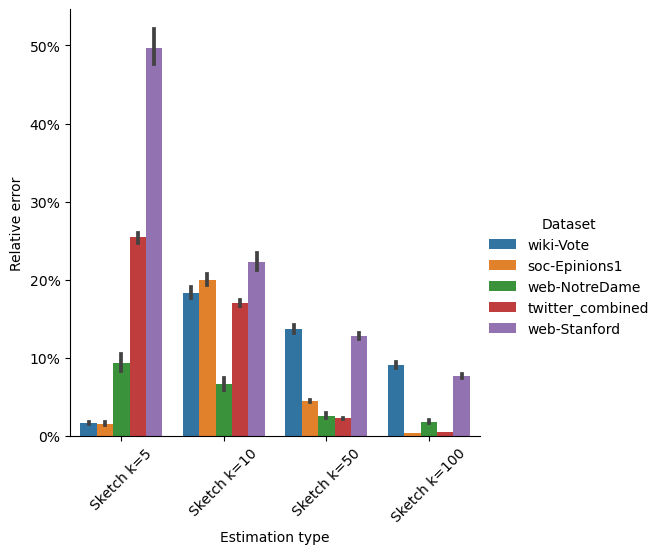

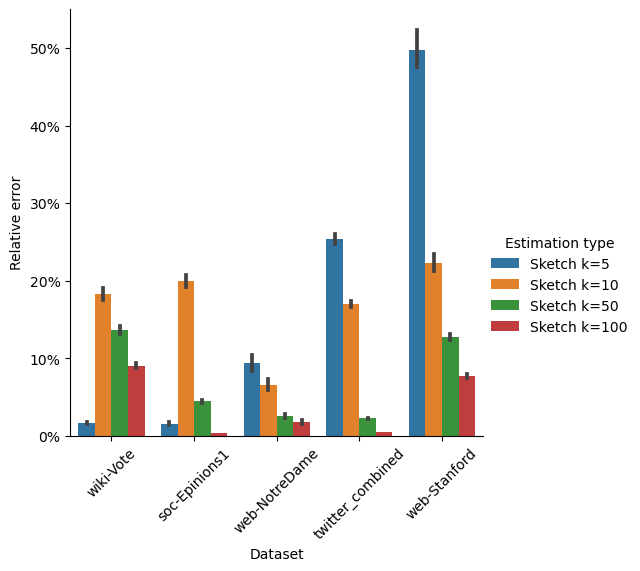

In [5]:
relative_error_label = "Relative error"
estimation_type_label = "Estimation type"
dataset_label = 'Dataset'

def results_data_cleaning(filepath: str, drop_headers: list[str]):
    df = pd.read_csv(filepath)
    for header in drop_headers:
        df.drop(header, axis=1, inplace=True)
    df.drop(df.tail(1).index,inplace=True) # we don't need the sum row
    df = df.melt(id_vars=['Node ids', 'TC'], var_name=estimation_type_label, value_name='Estimate')
    df[relative_error_label] = ((df['Estimate'] - df['TC']) / df['TC']).abs() * 100
    dataset = re.search(r'_[a-zA-Z0-9]+_(.+?).txt', filepath).group(1)
    df[dataset_label] = dataset
    return df

def results_plots(results_folder_path: str, drop_headers: list[str], plot_separate: bool, plot_combined: bool):
    filepaths: list[str] = []
    for root, dirs, files in os.walk(results_folder_path):
        for file in files:
            if "node_results" in file:
                path = os.path.join(root, file)
                filepaths.append(path)
    
    df_combined = pd.DataFrame()
    for filepath in filepaths:
        df = results_data_cleaning(filepath, drop_headers)
        df_combined = df_combined.append(df)
    
    if plot_separate:
        g = sns.catplot(x=estimation_type_label, y=relative_error_label, 
                        col=dataset_label, 
                        kind="bar", estimator=np.mean, data=df_combined)
        for ax in g.axes.flat:
            ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.show()
    
    if plot_combined:
        orders = hue_orders = [__ds_ordered_size__] # __ds_ordered_nodes__, __ds_ordered_edges__, 
        for hue_order in hue_orders:
            g = sns.catplot(x=estimation_type_label, y=relative_error_label, 
                            hue=dataset_label, hue_order=hue_order,
                            palette=__ds_palette__,
                            kind="bar", estimator=np.mean, data=df_combined)
            for ax in g.axes.flat:
                ax.yaxis.set_major_formatter(mtick.PercentFormatter())
            plt.xticks(rotation=45)
            plt.show()
            
        for order in orders:
            g = sns.catplot(x=dataset_label, y=relative_error_label, 
                            hue=estimation_type_label, 
                            order=order,
                            kind="bar", estimator=np.mean, data=df_combined)
            for ax in g.axes.flat:
                ax.yaxis.set_major_formatter(mtick.PercentFormatter())
            plt.xticks(rotation=45)
            plt.show()
    
drop_headers = ['Function', 'Summary']
results_folder_path: str = "results/v1-results"
results_plots(results_folder_path, drop_headers, False, True)


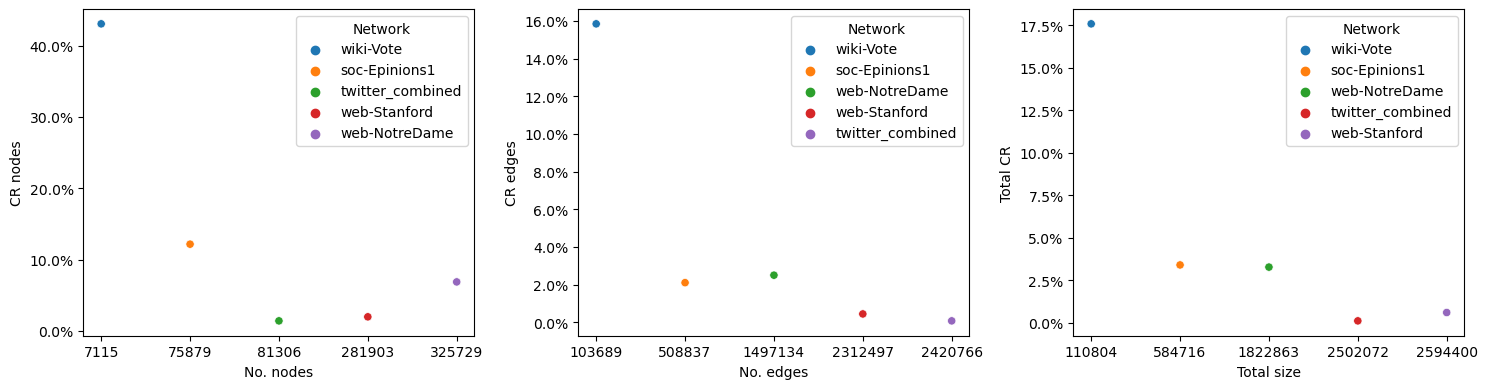

In [6]:
unlabeled_filepath: str = 'results/v1-results/2021-10-25_08h42m14s_results_N=1000.csv'
summary_plots(unlabeled_filepath, False)
# labeled_filepath: str = 'results/2021-10-23_13h26m51s_results_N=1000.csv'
# summary_plots(labeled_filepath, True)

In [7]:
filepath = 'results/2021-10-22_07h24m49s_results_N=1000.csv'
results = pd.read_csv(filepath)

results['Sum'] = results['No. nodes'] + results['No. edges']
results['Sketch creation time k=5'] = results['Sketch creation time k=5'] / 60
results['Sketch creation time k=10'] = results['Sketch creation time k=10'] / 60
results['Sketch creation time k=50'] = results['Sketch creation time k=50'] / 60
results = results.sort_values('Sum')
print(results)

fig, ax = plt.subplots()
ax.bar(results['Network'], results['Sketch creation time k=50'], label='k=50')
ax.bar(results['Network'], results['Sketch creation time k=10'], label='k=10')
ax.bar(results['Network'], results['Sketch creation time k=5'], label='k=5')
ax.set_xlabel("Network name")
ax.set_ylabel("Sketch creation time (min)")
ax.legend(loc='best')
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots()
ax.bar(results['Network'], results['No. edges'], label='Edges')
ax.bar(results['Network'], results['No. nodes'], label='Nodes', bottom=results['No. edges'])
ax.set_xlabel('Network name')
ax.set_ylabel('Nodes and Edges')
ax.legend(loc='best')
plt.xticks(rotation=90)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'results/2021-10-22_07h24m49s_results_N=1000.csv'